# Лінійна регресія: перенавчання та регуляризація

У цьому завдання ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх осередках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова **"Відповідь:".**

In [348]:
import pandas as pd
import numpy as np
# from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом __"bikes_rent.csv"__, в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знайомство з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [381]:
df = pd.read_csv("https://drive.google.com/uc?id=1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96", header=0)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.111,18.181,80.583,10.750,4.805,985
1,1,0,1,0,0,0,2,14.903,17.687,69.609,16.652,7.444,801
2,1,0,1,0,1,1,1,8.051,9.470,43.727,16.637,7.437,1349
3,1,0,1,0,2,1,1,8.200,10.606,59.044,10.740,4.801,1562
4,1,0,1,0,3,1,1,9.305,11.463,43.696,12.522,5.598,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 - немає свята, 1 - є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної __cnt__.

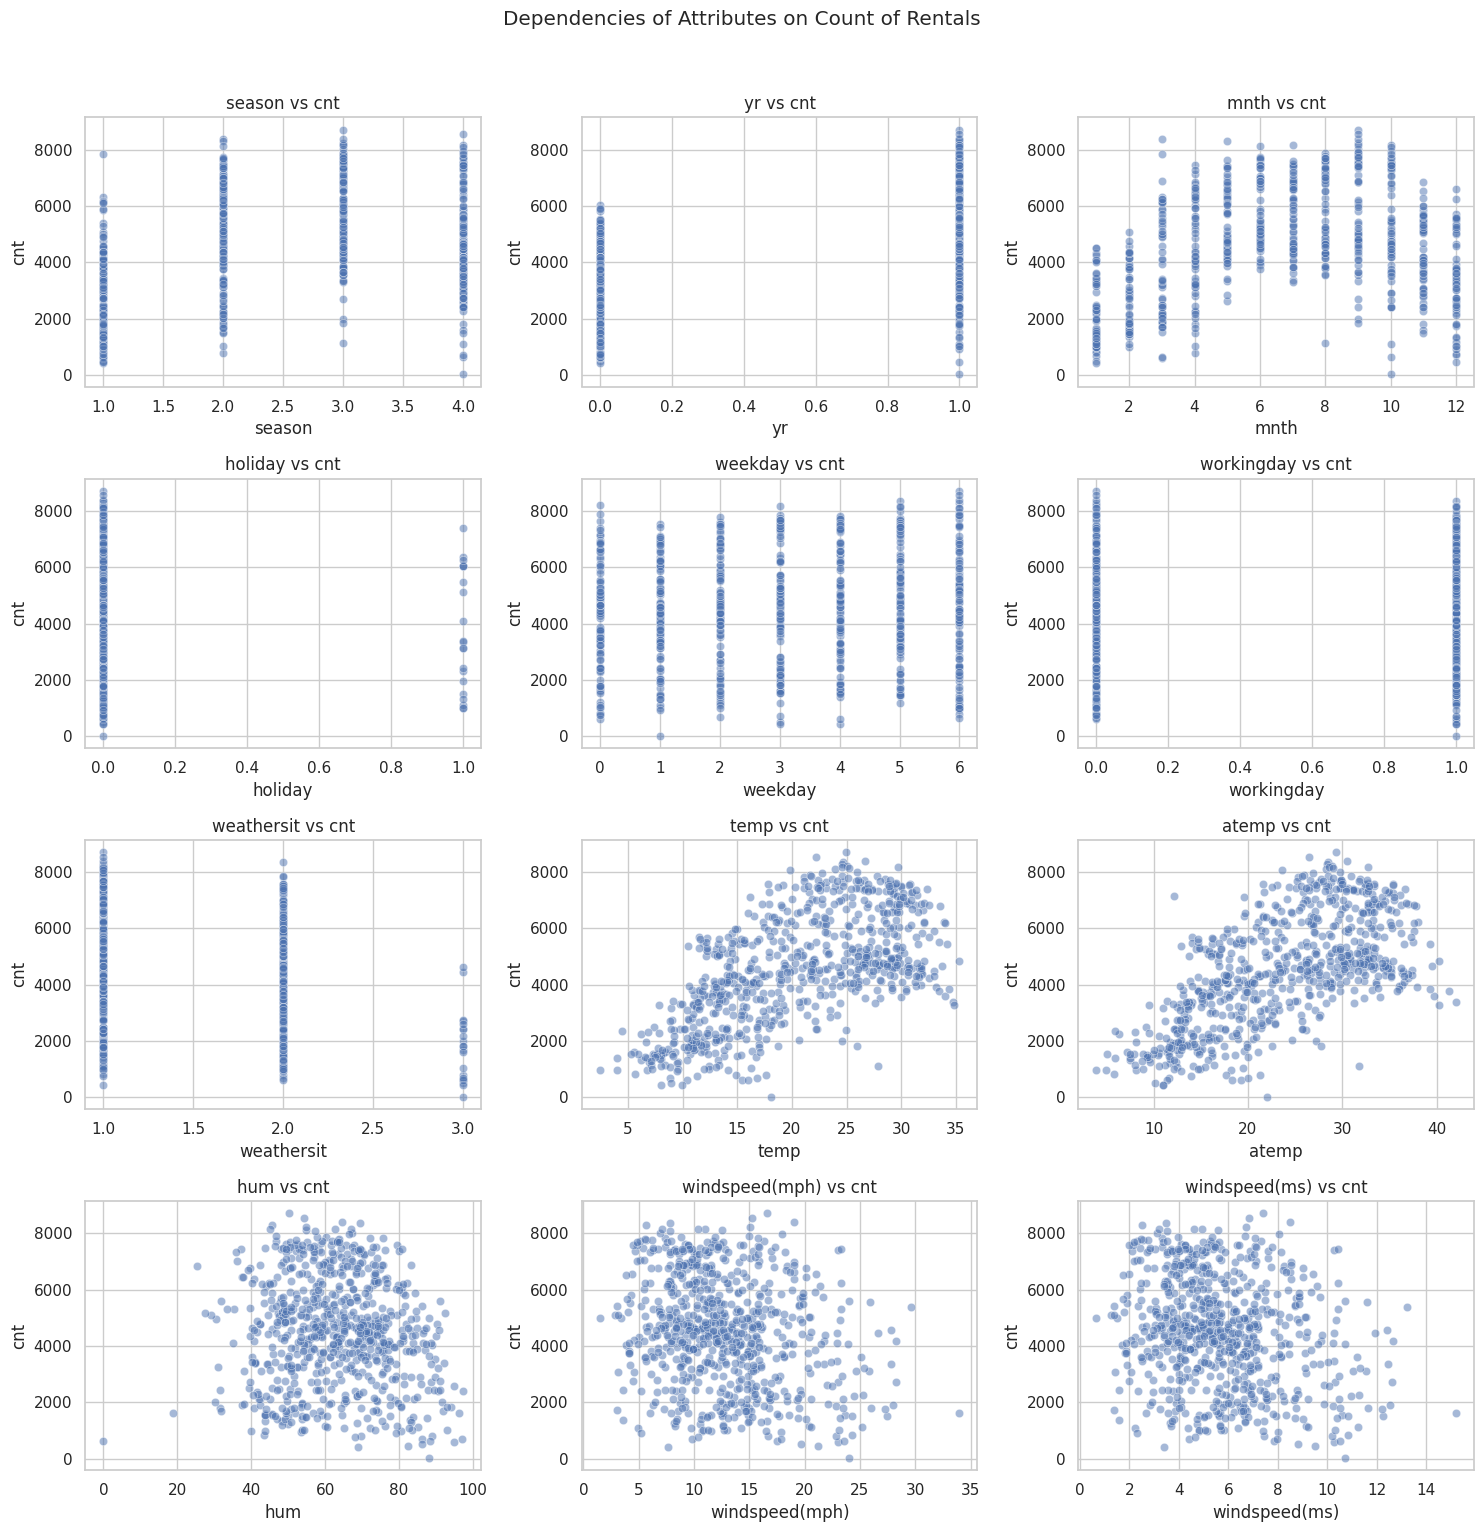

In [382]:
# seasons = df.groupby('season')
# fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
# attributes = ['season', 'yr', 'mnth',
#               'holiday', 'weekday', 'workingday',
#               'weathersit', 'temp', 'atemp',
#               'hum', 'windspeed(mph)', 'windspeed(ms)']

# for i, ax in enumerate(axes.flatten()):
#     attribute = attributes[i]
#     ax.scatter(df[attribute], df['cnt'], alpha=0.5)
#     ax.set_title(f'{attribute} vs cnt')
#     ax.set_xlabel(attribute)
#     ax.set_ylabel('Count of Rentals')

# plt.tight_layout()
# plt.show()


sns.set(style="whitegrid")
attributes = ['season', 'yr', 'mnth',
              'holiday', 'weekday', 'workingday',
              'weathersit', 'temp', 'atemp',
              'hum', 'windspeed(mph)', 'windspeed(ms)']

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
fig.suptitle('Dependencies of Attributes on Count of Rentals', y=1.02)

for i, attribute in enumerate(attributes):
    row, col = i // 3, i % 3
    sns.scatterplot(x=attribute, y='cnt', data=df, ax=axes[row, col], alpha=0.5)
    axes[row, col].set_title(f'{attribute} vs cnt')

plt.tight_layout()
plt.show()


__Питання:__
1. Яким є характер залежності кількості прокатів від місяця?

Кореляція 0.279 характеризує слабку позитивну лінійну залежність між місяцем і кількістю прокатів. Кількість робочих днів в місяці, температура та швидкість вітру не мають суттєвого впливу на прокати веловипедів. Чіткий тренд - в найхолодніші місяці найменша кількість прокатів. (з того що не є умовами аналізу датасету - це чинник канікул в період з червня до вересня).

2. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно

Такими ознаками є temp: температура в Цельсіях та
atemp: температура за відчуттями в Цельсіях

In [383]:
correlation = df['mnth'].corr(df['cnt'])
print(f"Кореляція між місяцем та кількістю прокатів: {correlation}")

Кореляція між місяцем та кількістю прокатів: 0.27997711221927124


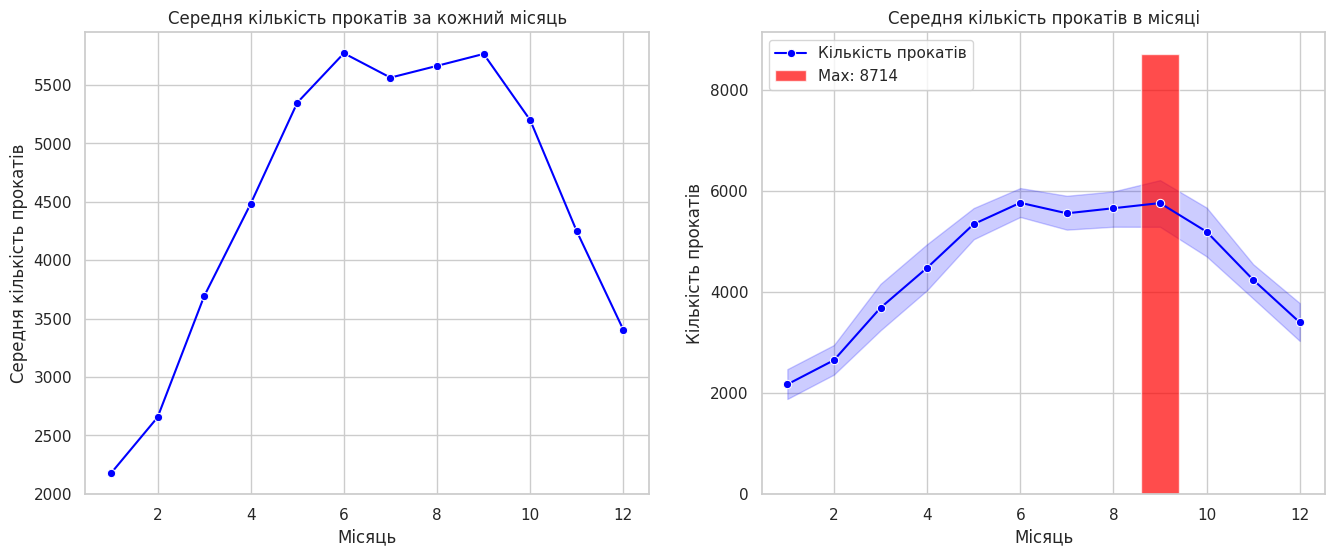

In [384]:
df_monthly = df.groupby('mnth')['cnt'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.lineplot(x='mnth', y='cnt', data=df_monthly, marker='o', color='blue', ax=axes[0])
axes[0].set_title('Середня кількість прокатів за кожний місяць')
axes[0].set_xlabel('Місяць')
axes[0].set_ylabel('Середня кількість прокатів')

sns.lineplot(x='mnth', y='cnt', data=df, label='Кількість прокатів', marker='o', color='blue', ax=axes[1])

max_idx = df['cnt'].idxmax()
max_value = df['cnt'].max()
max_month = df.loc[max_idx, 'mnth']
axes[1].bar(max_month, max_value, color='red', label=f'Max: {max_value}', alpha=0.7)

axes[1].set_title('Середня кількість прокатів в місяці')
axes[1].set_xlabel('Місяць')
axes[1].set_ylabel('Кількість прокатів')
axes[1].legend()

plt.show()


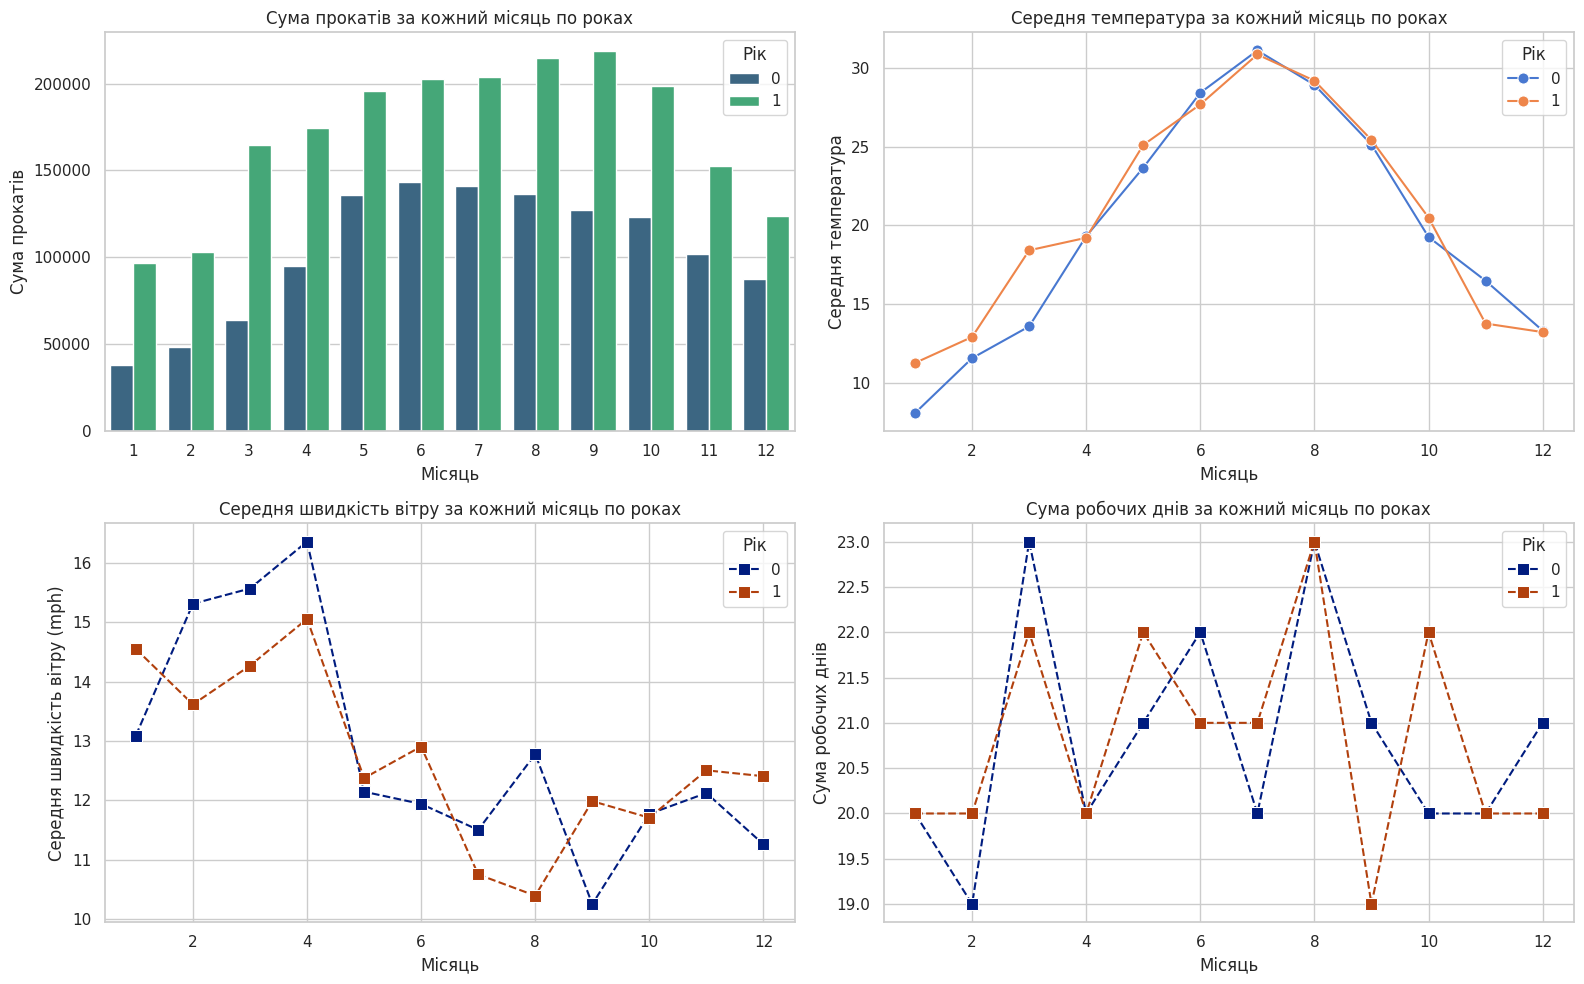

In [385]:
df_grouped = df.groupby(['mnth', 'yr']).agg({'cnt': 'sum', 'workingday': 'sum', 'temp': 'mean', 'windspeed(mph)': 'mean'}).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

ax1 = sns.barplot(x='mnth', y='cnt', hue='yr', data=df_grouped, palette='viridis', ax=axes[0, 0])
ax1.set_title('Сума прокатів за кожний місяць по роках')
ax1.set_xlabel('Місяць')
ax1.set_ylabel('Сума прокатів')
ax1.legend(title='Рік')

ax2 = sns.lineplot(x='mnth', y='temp', hue='yr', data=df_grouped, marker='o', linestyle='-', markersize=8, palette='muted', ax=axes[0, 1])
ax2.set_title('Середня температура за кожний місяць по роках')
ax2.set_xlabel('Місяць')
ax2.set_ylabel('Середня температура')
ax2.legend(title='Рік', loc='upper right')

ax3 = sns.lineplot(x='mnth', y='windspeed(mph)', hue='yr', data=df_grouped, marker='s', linestyle='--', markersize=8, palette='dark', ax=axes[1, 0])
ax3.set_title('Середня швидкість вітру за кожний місяць по роках')
ax3.set_xlabel('Місяць')
ax3.set_ylabel('Середня швидкість вітру (mph)')
ax3.legend(title='Рік', loc='upper right')

ax4 = sns.lineplot(x='mnth', y='workingday', hue='yr', data=df_grouped, marker='s', linestyle='--', markersize=8, palette='dark', ax=axes[1, 1])
ax4.set_title('Сума робочих днів за кожний місяць по роках')
ax4.set_xlabel('Місяць')
ax4.set_ylabel('Сума робочих днів')
ax4.legend(title='Рік', loc='upper right')

plt.tight_layout()
plt.show()


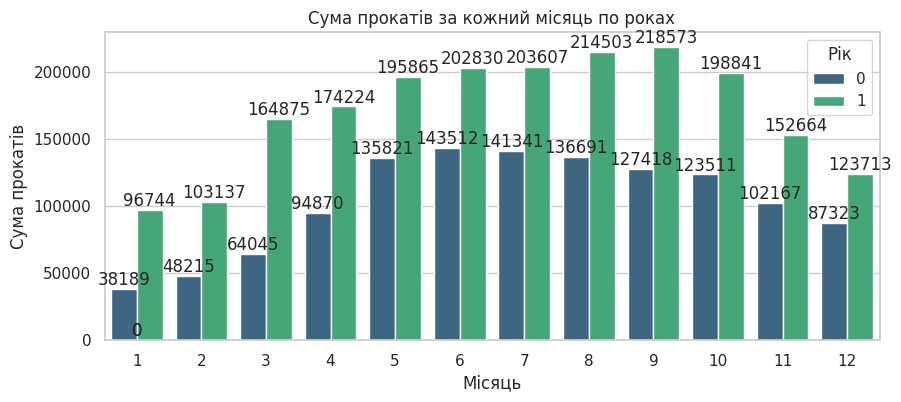

In [386]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))

df_grouped = df.groupby(['mnth', 'yr'])['cnt'].sum().reset_index()

ax = sns.barplot(x='mnth', y='cnt', hue='yr', data=df_grouped, palette='viridis')

plt.title('Сума прокатів за кожний місяць по роках')
plt.xlabel('Місяць')
plt.ylabel('Сума прокатів')
plt.legend(title='Рік')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')

plt.show()

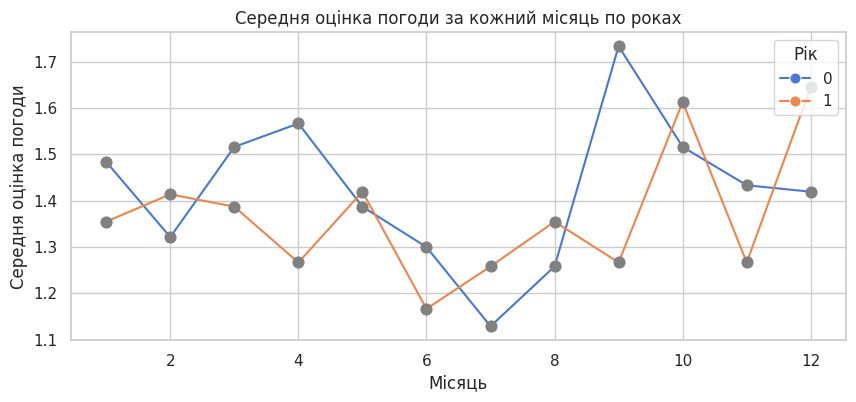

In [387]:
df_grouped = df.groupby(['mnth', 'yr']).agg({'weathersit': 'mean'}).reset_index()

weather_palette = {1: 'green', 2: 'yellow', 3: 'orange', 4: 'red'}

plt.figure(figsize=(10, 4))
ax = sns.lineplot(x='mnth', y='weathersit', hue='yr', data=df_grouped, marker='o', linestyle='-', markersize=8, palette='muted')

for line, year, weather in zip(ax.lines, df_grouped['yr'].unique(), df_grouped['weathersit'].unique()):
    color = weather_palette.get(weather, 'gray')
    line.set_markerfacecolor(color)
    line.set_markeredgecolor(color)

plt.title('Середня оцінка погоди за кожний місяць по роках')
plt.xlabel('Місяць')
plt.ylabel('Середня оцінка погоди')
plt.legend(title='Рік', loc='upper right')

plt.show()

In [388]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_features.corr()
correlated_features = correlation_matrix['cnt'].sort_values(ascending=False).index[1:3]
print(f"Ознаки, що мають найвищу кореляцію з 'cnt': {correlated_features}")
print(f"від яких кількість прокатів, ймовірно, залежить лінійно")

Ознаки, що мають найвищу кореляцію з 'cnt': Index(['atemp', 'temp'], dtype='object')
від яких кількість прокатів, ймовірно, залежить лінійно


In [389]:
print("Кореляції з 'cnt':")
correlation_matrix['cnt']

Кореляції з 'cnt':


season            0.406
yr                0.567
mnth              0.280
holiday          -0.068
weekday           0.067
workingday        0.061
weathersit       -0.297
temp              0.627
atemp             0.631
hum              -0.101
windspeed(mph)   -0.235
windspeed(ms)    -0.235
cnt               1.000
Name: cnt, dtype: float64

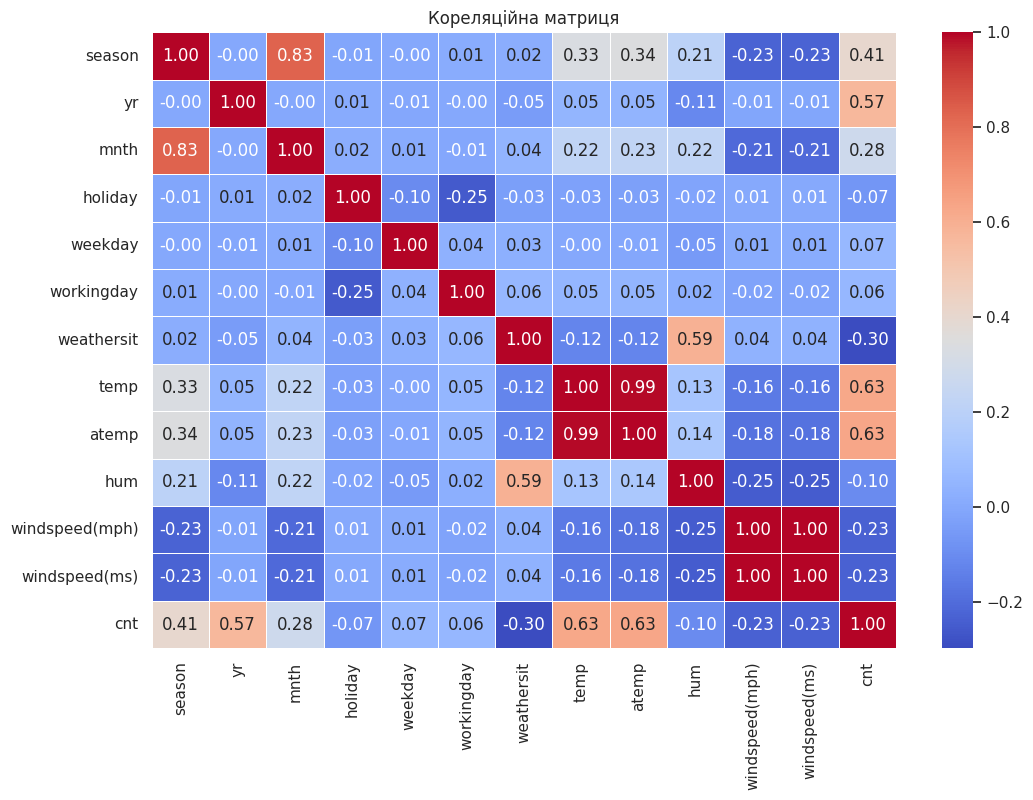

In [390]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Кореляційна матриця')
plt.show()

## Завдання 2

Давайте суворіше оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Доброю мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.


Порахуйте кореляції всіх ознак, крім останньої, з останньою за допомогою методу `corrwith`.

In [391]:
# від correlation_matrix['cnt'] відрізняється відсутністю 'cnt'
correlations = df.iloc[:, :-1].corrwith(df['cnt'])
correlations

season            0.406
yr                0.567
mnth              0.280
holiday          -0.068
weekday           0.067
workingday        0.061
weathersit       -0.297
temp              0.627
atemp             0.631
hum              -0.101
windspeed(mph)   -0.235
windspeed(ms)    -0.235
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі одна на одну. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [392]:
selected_features = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
correlations = selected_features.corr()
correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000,0.992,0.127,-0.158,-0.158,0.627
atemp,0.992,1.000,0.140,-0.184,-0.184,0.631
hum,0.127,0.140,1.000,-0.248,-0.248,-0.101
windspeed(mph),-0.158,-0.184,-0.248,1.000,1.000,-0.235
windspeed(ms),-0.158,-0.184,-0.248,1.000,1.000,-0.235
cnt,0.627,0.631,-0.101,-0.235,-0.235,1.000


На діагоналях, як і годиться, стоять одиниці. Однак у матриці є ще дві пари стовпців, які сильно корелюють: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переклад одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Наостанок подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак


In [393]:
# df.mean()
means = df.mean()
print("Масштаб числових ознак:")
print(means[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']])
print("\nЧастки для бінарних ознак:")
means[['yr', 'holiday', 'workingday']]

Масштаб числових ознак:
temp             20.311
atemp            23.718
hum              62.789
windspeed(mph)   12.763
windspeed(ms)     5.705
dtype: float64

Частки для бінарних ознак:


yr           0.501
holiday      0.029
workingday   0.684
dtype: float64

Ознаки мають різний масштаб, отже для подальшої роботи нам краще унормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звісно, ми могли б одразу видалити дублікати, але давайте подивимося, як би відбувалося навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це потрібно для крос-валідації.

In [394]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [395]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

# X = df.iloc[:, :-1]
# y = df["cnt"]

In [396]:
df_shuffled.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509,23.453,73.375,11.667,5.215,6606
33,1,0,2,0,4,1,1,7.665,8.894,43.783,18.609,8.319,1550
300,4,0,10,0,5,1,2,13.564,15.941,58.583,15.375,6.873,3747
456,2,1,4,0,0,0,2,17.459,20.864,67.625,11.542,5.160,6041
633,4,1,9,0,2,1,1,22.550,27.209,57.000,15.834,7.078,7538


In [397]:
# #тест варіанту2 -> дані співпадають
# features_to_scale = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
# df[features_to_scale] = scale(df[features_to_scale])

# df_shuffled = shuffle(df, random_state=42)
# df_shuffled_lc = df_shuffled.iloc[:, :-1]
# df_shuffled_lc.head()

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [398]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [399]:
model = LinearRegression().fit(X, y)

In [400]:
model.coef_

array([ 5.70863796e+02,  1.02196538e+03, -1.41301745e+02, -8.67593446e+01,
        1.37225064e+02,  5.63918818e+01, -3.30226462e+02,  3.67483733e+02,
        5.85549386e+02, -1.45614306e+02,  1.24571384e+13, -1.24571384e+13])

In [401]:
model.intercept_

4504.354528214392

In [402]:
weights_df = pd.DataFrame(list(zip(df.columns[:-1], model.coef_)),
                          columns=['Feature', 'Weight'])

pd.set_option('display.float_format', lambda x: '%.3f' % x)
weights_df

,Feature,Weight
0,season,570.864
1,yr,1021.965
2,mnth,-141.302
3,holiday,-86.759
4,weekday,137.225
5,workingday,56.392
6,weathersit,-330.226
7,temp,367.484
8,atemp,585.549
9,hum,-145.614


In [403]:
# #тест варіанту2 -> дані співпадають
# regressor = LinearRegression()
# regressor.fit(X, y)
# weights = regressor.coef_

# for item in zip(df.columns[:-1], model.coef_):
#   print (f'{item[0]}: {item[1]}')

Ми бачимо, що ваги за лінійно-залежних ознак за модулем значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаймо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Що більш залежні ознаки, то менший визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менш корельованих змінних такого не сталося, проте на практиці завжди варто уважно слідкувати за коефіцієнтами за схожих ознак.

Для того, щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізованого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

### Завдання 6
Спробуймо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регрессори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [404]:
from sklearn.linear_model import Lasso, Ridge

lasso_regressor = Lasso().fit(X, y)

lasso_weights_df = pd.DataFrame(list(zip(df.columns[:-1], lasso_regressor.coef_)),
                                columns=['Feature', 'Weight'])
lasso_weights_df

,Feature,Weight
0,season,560.242
1,yr,1019.463
2,mnth,-128.731
3,holiday,-86.153
4,weekday,137.348
5,workingday,55.212
6,weathersit,-332.370
7,temp,376.363
8,atemp,576.531
9,hum,-144.129


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [405]:
ridge_regressor = Ridge().fit(X, y)

ridge_weights_df = pd.DataFrame(list(zip(df.columns[:-1], ridge_regressor.coef_)),
                                columns=['Feature', 'Weight'])
ridge_weights_df

,Feature,Weight
0,season,563.065
1,yr,1018.948
2,mnth,-131.873
3,holiday,-86.746
4,weekday,138.005
5,workingday,55.903
6,weathersit,-332.350
7,temp,386.458
8,atemp,566.347
9,hum,-145.071


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги до списку `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги до списку `coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [414]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha).fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    ridge_regressor = Ridge(alpha=alpha).fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)


lasso_weights_df = pd.DataFrame(coefs_lasso, columns=df.columns[:-1])
ridge_weights_df = pd.DataFrame(coefs_ridge, columns=df.columns[:-1])

print("Lasso Coefficients:")
lasso_weights_df

Lasso Coefficients:


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,560.242,1019.463,-128.731,-86.153,137.348,55.212,-332.370,376.363,576.531,-144.129,-197.140,-0.000
1,410.970,977.019,-0.000,-53.449,91.943,17.537,-318.126,322.830,610.032,-91.069,-145.066,-0.000
2,370.077,935.945,0.000,-12.162,48.889,0.000,-308.806,269.417,632.503,-27.504,-93.775,-0.000
3,332.836,891.870,0.000,-0.000,0.000,0.000,-279.617,211.052,662.921,-0.000,-50.155,-0.000
4,298.134,845.653,0.000,-0.000,0.000,0.000,-235.571,124.145,725.379,-0.000,-12.646,-0.000
5,258.927,799.237,0.000,-0.000,0.000,0.000,-190.822,72.076,750.363,-0.000,-0.000,-0.000
6,217.428,752.721,0.000,-0.000,0.000,0.000,-145.713,37.715,756.297,-0.000,-0.000,-0.000
7,175.930,706.204,0.000,-0.000,0.000,0.000,-100.605,3.661,761.926,-0.000,-0.000,-0.000
8,134.628,659.633,0.000,-0.000,0.000,0.000,-55.511,0.000,737.348,-0.000,-0.000,-0.000
9,93.352,613.055,0.000,-0.000,0.000,0.000,-10.419,0.000,709.131,-0.000,-0.000,-0.000


In [407]:
print("\nRidge Coefficients:")
ridge_weights_df


Ridge Coefficients:


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,563.065,1018.948,-131.873,-86.746,138.005,55.903,-332.350,386.458,566.347,-145.071,-99.259,-99.259
1,461.179,954.308,-41.565,-84.913,126.604,54.252,-313.275,458.901,481.444,-151.291,-101.627,-101.627
2,403.977,898.084,5.674,-81.911,117.941,52.728,-298.409,455.290,467.431,-152.686,-102.102,-102.102
3,366.604,848.463,34.027,-78.772,110.680,51.257,-286.125,447.480,455.754,-151.483,-102.005,-102.005
4,339.745,804.251,52.490,-75.717,104.403,49.842,-275.486,438.510,444.764,-148.944,-101.586,-101.586
5,319.159,764.561,65.152,-72.820,98.879,48.485,-266.003,429.214,434.235,-145.698,-100.965,-100.965
6,302.636,728.709,74.138,-70.099,93.956,47.185,-257.391,419.926,424.122,-142.089,-100.209,-100.209
7,288.913,696.146,80.660,-67.555,89.529,45.943,-249.471,410.800,414.409,-138.317,-99.361,-99.361
8,277.213,666.430,85.459,-65.179,85.519,44.757,-242.124,401.912,405.086,-134.499,-98.449,-98.449
9,267.031,639.195,89.012,-62.959,81.865,43.625,-235.264,393.298,396.138,-130.710,-97.493,-97.493


Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

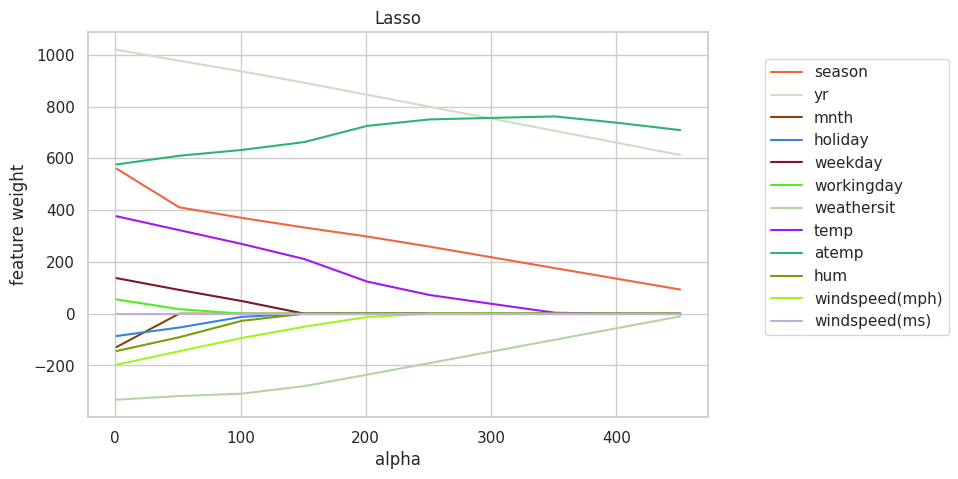

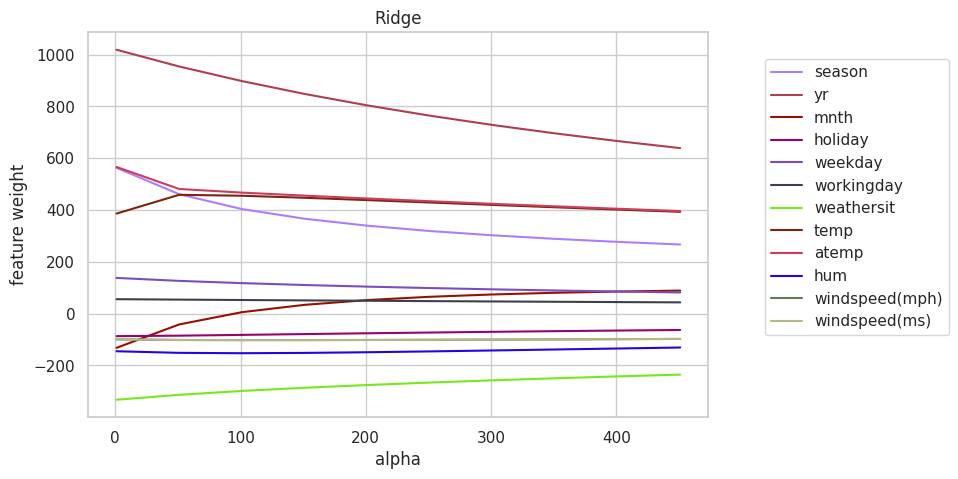

In [415]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge чи Lasso) агресивніше зменшує ваги за одного й того самого alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ній менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1. Lasso більш агресивно зменшує ваги. Деякі з них рівні нулю.
2. Penalty за кожен ненульовий коефіцієнт стає дуже великим і модель (регуляризатор Lasso) буде намагатися зменшити їх кількість, тобто всі ваги.
3.Lasso може виключити непотрібні ознаки. Ridge зменшує величину для коефіцієнтів, але не прирівнює до нуля.
4. Обидва. Lasso маленькі значення обнулить, а Ridge великі ваги буде сильно "штрафувати".

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна обирати `alpha` за значенням MSE на навчальній вибірці, бо тоді ми не зможемо оцінити, як модель робитиме передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну і тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбивок вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частини, і щоразу брати одну з них як тестову, а з решти блоків складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ зберігатиметься вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [421]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    # x = map(lambda e: e[0], data)
    # y = map(lambda e: e[1], data)

    x, y = zip(*data) #added
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

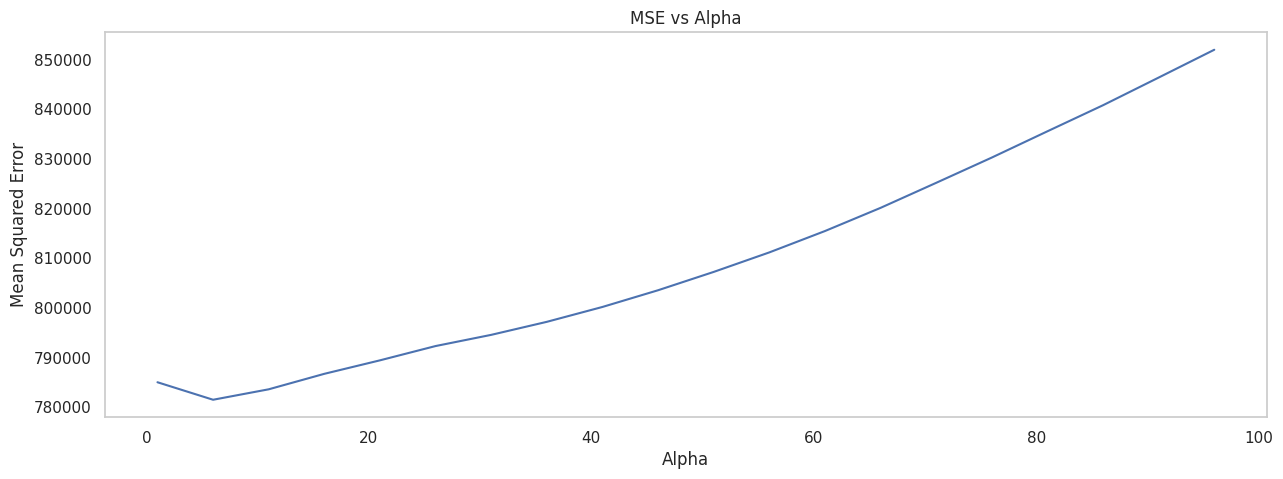

Selected Alpha: 6

Feature Coefficients:
season: 532.0189828413535
yr: 1015.0602226430595
mnth: -100.03952614356629
holiday: -83.29395987529904
weekday: 132.50446549095795
workingday: 51.557085614073735
weathersit: -330.5598567399817
temp: 370.67985503003405
atemp: 581.396931065498
hum: -140.00740550068844
windspeed(mph): -191.77140847135036
windspeed(ms): -2.6854702314758792e-08


In [427]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3, random_state=42).fit(X, y)

avg_mse_values = np.mean(regressor.mse_path_, axis=1)

create_plot(list(zip(regressor.alphas_, avg_mse_values)),
            'MSE vs Alpha',
            'Alpha', 'Mean Squared Error', figsize=(15, 5))

selected_alpha = regressor.alpha_
print(f"Selected Alpha: {selected_alpha}")

coefficients = list(zip(df.columns[:-1], regressor.coef_))
print("\nFeature Coefficients:")
for feature, coefficient in coefficients:
    print(f"{feature}: {coefficient}")


In [434]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score, cross_validate

alpha_value = 1.0
model = ElasticNet(alpha=alpha_value, l1_ratio=0.5, fit_intercept=True)
scores = cross_val_score(model, X, y, cv=5)
scores

array([0.76516106, 0.72344224, 0.74971233, 0.6891743 , 0.76397807])

In [459]:
# #тестовий варіант2 ->

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

# X = df[df.columns[:-1]]
# y = df[df.columns[-1]]


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# alphas = np.arange(1, 100, 5)
# lasso_regressor = LassoCV(alphas=alphas, cv=3).fit(X_train_scaled, y_train)

# avg_mse_values = np.mean(lasso_regressor.mse_path_, axis=1)

# create_plot(list(zip(lasso_regressor.alphas_, avg_mse_values)),
#             'MSE vs Alpha',
#             'Alpha', 'Mean Squared Error', figsize=(15, 5))

# selected_alpha = lasso_regressor.alpha_
# print(f"Selected Alpha: {selected_alpha}")

# coefficients = list(zip(df.columns[:-1], lasso_regressor.coef_))
# print("\nFeature Coefficients:")
# for feature, coefficient in coefficients:
#     print(f"{feature}: {coefficient}")

Отже, ми вибрали деякий параметр регуляризації. Давайте подивимося, які б ми обирали alpha, якби ділили вибірку тільки один раз на навчальну і тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, відповідні мінімум `MSE` на кожне розбиття (тобто є за столбцями).
На трьох окремих графіках візуалізуйте столбці `mse_path_`.


Alpha: 96, Min MSE: 733725.7604052249
Alpha: 91, Min MSE: 799433.1673691692
Alpha: 86, Min MSE: 796979.8955193626


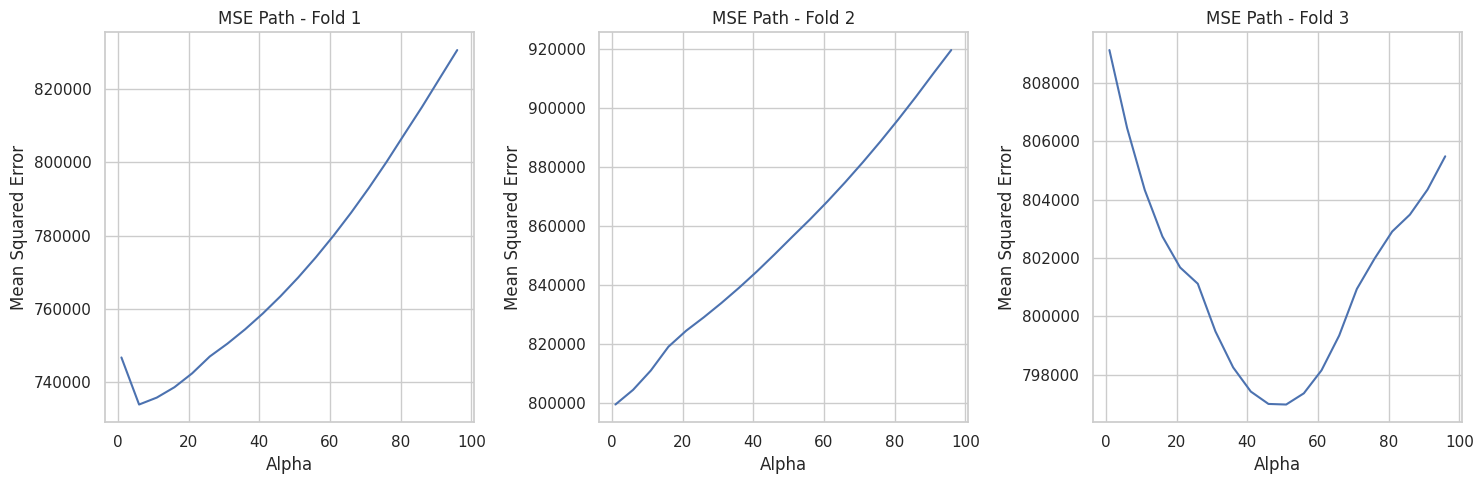

In [453]:
for i, alpha in enumerate(regressor.alphas_):
    if i < regressor.mse_path_.shape[1]:
        min_mse = np.min(regressor.mse_path_[:, i])
        print(f"Alpha: {alpha}, Min MSE: {min_mse}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    axs[i].plot(regressor.alphas_, regressor.mse_path_[:, i])
    axs[i].set_title(f'MSE Path - Fold {i + 1}')
    axs[i].set_xlabel('Alpha')
    axs[i].set_ylabel('Mean Squared Error')

plt.tight_layout()
plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. Під час вибору `alpha` на крос-валідації ми обираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як заведено в аналізі даних, давайте проінтерпретуємо результат. Дайте відповідь на такі запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що що більше значення цих ознак, то більше людей захочуть узяти велосипеди?

__Відповідь:__

Top 4 features with the largest positive coefficients:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535
temp: 370.67985503003405


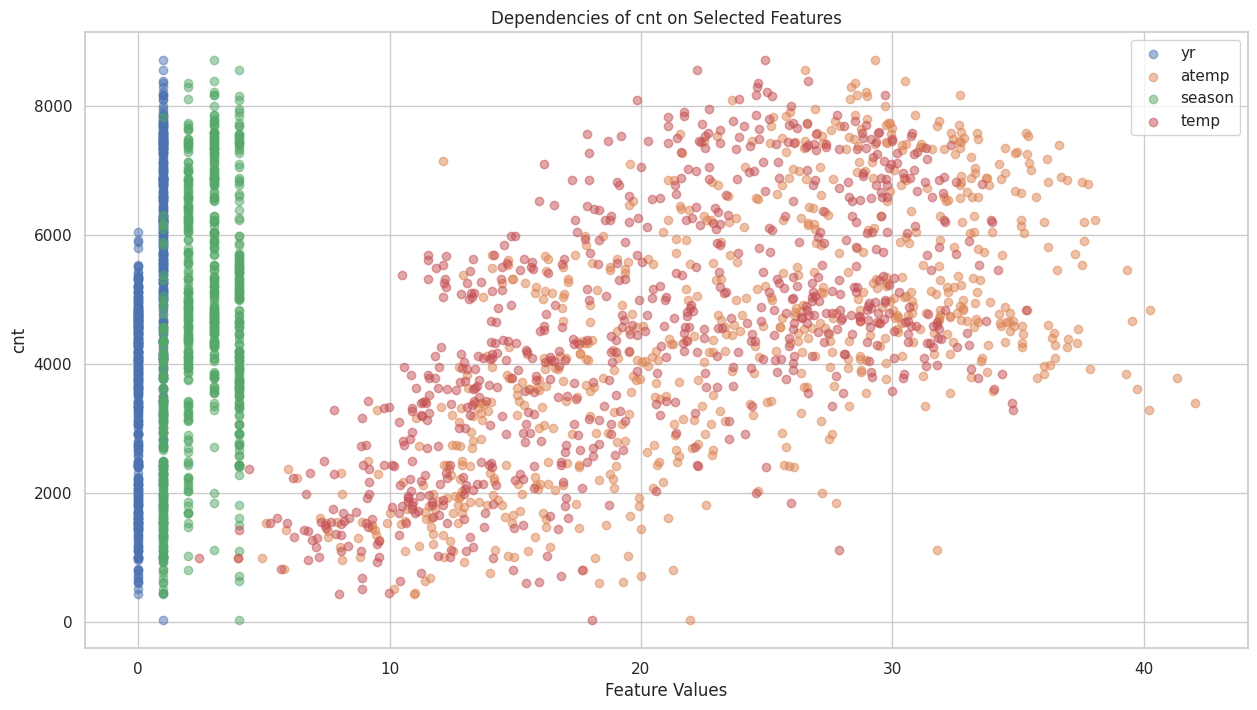

In [455]:
top_features = sorted(list(zip(df.columns[:-1], regressor.coef_)), key=lambda x: x[1], reverse=True)[:4]
selected_features = [feature for feature, _ in top_features]

print("Top 4 features with the largest positive coefficients:")
for feature, coefficient in top_features:
    print(f"{feature}: {coefficient}")

# selected_features = ["yr", "atemp", "season", "temp"]

plt.figure(figsize=(15, 8))
for feature in selected_features:
    plt.scatter(df[feature], df['cnt'], label=feature, alpha=0.5)

plt.title('Dependencies of cnt on Selected Features')
plt.xlabel('Feature Values')
plt.ylabel('cnt')
plt.legend()
plt.show()

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем від'ємними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно спадну лінійну залежність? Чи логічно стверджувати, що чим більшою є величина цих ознак, тим менше людей захочуть узяти велосипеди?

__Відповідь:__

Top 3 features with the largest absolute negative coefficients:
yr: 1015.0602226430595
atemp: 581.396931065498
season: 532.0189828413535


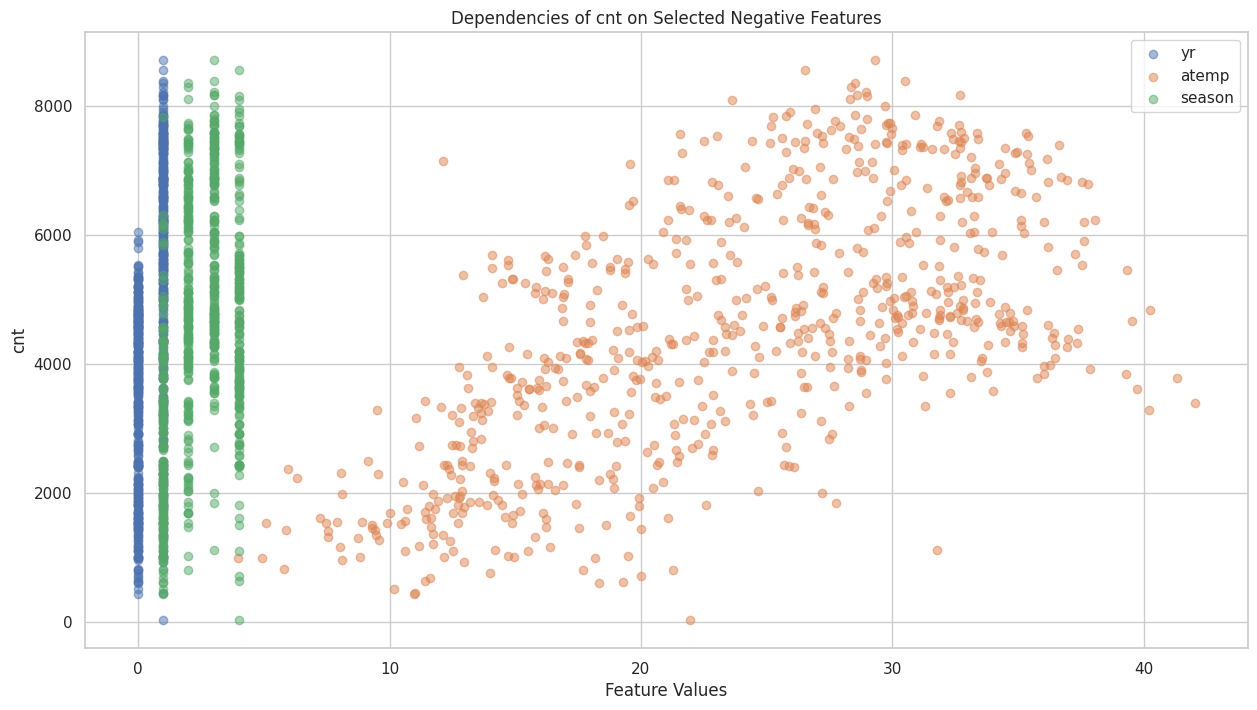

In [457]:
top_negative_features = sorted(list(zip(df.columns[:-1],
                                        regressor.coef_)),
                               key=lambda x: abs(x[1]),
                               reverse=True)[:3]

selected_negative_features = [feature for feature, _ in top_negative_features]

print("Top 3 features with the largest absolute negative coefficients:")
for feature, coefficient in top_negative_features:
    print(f"{feature}: {coefficient}")

plt.figure(figsize=(15, 8))

for feature in selected_negative_features:
    plt.scatter(df[feature], df['cnt'], label=feature, alpha=0.5)

plt.title('Dependencies of cnt on Selected Negative Features')
plt.xlabel('Feature Values')
plt.ylabel('cnt')
plt.legend()
plt.show()


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< $1e^{-3}$). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правильно, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [431]:
near_zero_features = [(feature, coefficient) for feature,
                      coefficient in zip(df.columns[:-1],
                                         regressor.coef_) if abs(coefficient) < 1e-3]

print("Features with coefficients near zero:")
for feature, coefficient in near_zero_features:
    print(f"{feature}: {coefficient}")

Features with coefficients near zero:
windspeed(ms): -2.6854702314758792e-08


In [458]:
correlation_matrix['windspeed(ms)']

season           -0.229
yr               -0.012
mnth             -0.208
holiday           0.006
weekday           0.014
workingday       -0.019
weathersit        0.040
temp             -0.158
atemp            -0.184
hum              -0.248
windspeed(mph)    1.000
windspeed(ms)     1.000
cnt              -0.235
Name: windspeed(ms), dtype: float64

Відповідь:

Модель Lasso використовує L1-регуляризацію, яка має тенденцію зменшувати коефіцієнти ознак до нуля, оскільки вважає ознаки windspeed недостатньо важливими.

Коефіцієнт кореляції вказує на слабкий взаємозв'язок.

Тому, швидкість вітру не впливає на попит велосипедів.



### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як добирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться кілька разів навчати модель. Такий процес займає багато часу, особливо якщо потрібно навчатися на великих обсягах даних.